In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits
from skimage.filters import threshold_otsu
from scipy.ndimage import shift

from sfilter import sfilter

In [2]:
# ----------------------------- c_jk -----------------------------------

def c_jk(data, Dpix):
    nx = 2 * Dpix + 2 # ширина окна для автокорреляции зрачка (должно быть минимум в 2 раза больше, чем ширина зрачка)
    img = data
    data_pupil = np.pad(img, ((Dpix - img.shape[0], 0), (0, Dpix - img.shape[1])), 'constant', constant_values=(0))
    I0c = (data_pupil != 0) * int(1)
    I0c = np.pad(I0c, ((nx - I0c.shape[0])//2, (nx - I0c.shape[1])//2), 'constant', constant_values=(0))
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(I0c)*np.fft.fft2(I0c).conjugate())))
    res /= np.max(res)
    
    return res

# ----------------------------- Монохроматическая гамма -----------------------------------

def gamma_mono(Cn2, D, Dpix, z, lambda_):
    nx = 2 * Dpix + 2
    const = 9.69*pow(10, -3)*16*pow(np.pi, 2) # константа перед интегралом 
        
    f_scale = Dpix/(D*nx) # шаг по частоте, [м^-1]
    delta = D/Dpix # шаг апертуры (соотношение между 1 пикселем и метрами, т.е. 1 пикс = 0.01 м) 

    xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
    fx = f_scale * xx 
    fy = f_scale * yy
    
    def gamma_mono_int(fx, fy, xx, yy, z, lambda_, delta): 
        def aperture_func(fx, fy, delta): 
            res = np.abs(np.sinc(delta*(-fx))*np.sinc(delta*(-fy)))**2
            return res
    
        def abs_f(fx, fy):
            res = pow(np.sqrt(fx**2+fy**2), -11./3.)
            res[np.isnan(res)] = 0
            return res

        def sin(fx, fy, z, lambda_): 
            res = pow(np.sin(np.pi*z*lambda_*(fx**2+fy**2)), 2) / pow(lambda_, 2)
            res[np.isnan(res)] = 0
            
            plt.imshow(res)
            plt.colorbar()
            plt.title('Фильтр Френеля')
            
            return res
        
# экспонента не нужна, потому что она отвечает за вычисление преобразования Фурье. 
# Тут она учитывается когда мы считаем Фурье-образ   

        res = abs_f(fx, fy) * sin(fx, fy, z, lambda_) * aperture_func(fx, fy, delta)
        res[np.isnan(res)] = 0
    
        return np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(res))))
    
    return Cn2 * const * gamma_mono_int(fx, fy, xx, yy, z, lambda_, delta) * pow(f_scale, 2) * nx * nx

# ----------------------------- Полихроматическая гамма -----------------------------------

def gamma_poly(Cn2, D, Dpix, z, Vx, Vy, latency, sec_per_frame):
    nx = 2 * Dpix + 2 # размер окна автокорреляции зрачка, должно быть в 2 раза больше чем размер зрачка
    const = 9.69*pow(10, -3)*16*pow(np.pi, 2) # константа перед интегралом 
        
    f_scale = Dpix/(D*nx) # шаг по частоте, [м^-1]
    delta = D/Dpix # шаг апертуры (соотношение между 1 пикселем и метрами, т.е. 1 пикс = 0.01 м) 

    xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
    fx = f_scale * xx 
    fy = f_scale * yy
    
    t = sec_per_frame * latency
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    
    def gamma_poly_int(fx, fy, xx, yy, z, lambda_, delta): 
        def aperture_func(fx, fy, delta): 
            res = np.abs(np.sinc(delta*(-fx))*np.sinc(delta*(-fy)))**2
            return res
    
        def abs_f(fx, fy):
            res = pow(np.sqrt(fx**2+fy**2), -11./3.)
            res[np.isnan(res)] = 0
            return res
        
        S = sfilter(D=D, Dpix=Dpix, z=z)    
    
        res = abs_f(fx, fy) * S * aperture_func(fx, fy, delta)
        res[np.isnan(res)] = 0
    
        return np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(res))))
    
    res = Cn2 * const * gamma_poly_int(fx, fy, xx, yy, z, lambda_, delta) * pow(f_scale, 2) * nx * nx

    res2 = shift(res, (-Xpix, -Ypix), order=5)

    return res2
 
# ----------------------------- Корреляция -----------------------------------

def correlate(data, latency): 
    correlation = np.zeros_like(data)
    def correlate_fft(img1, img2):
        corr = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(img1)*np.fft.fft2(img2).conjugate()))) # np.real; np.abs
        # видно, что значения мнимой части очень маленькие, поэтому можно выводить сразу действительную часть
        corr /= np.max(corr)
        return corr
    
    for i in range(data.shape[0] - latency):
        correlation[i] = correlate_fft(data[i], data[i + latency])
    
    return np.mean(correlation, axis=0)
    
# ----------------------------- Получение изображения зрачка -----------------------------------

def pupil(data):  
    image_average = np.mean(data, axis=0) # средний кадр серии
    image_binary = (image_average > threshold_otsu(image_average)) * int(255) # маска среднего кадра
    
    def image_normalize(data): # нормировка потока, <I> = 0
        return (data)/(image_average) - 1

    def image_mask(data): # вырез зрачка
        return image_normalize(data) * image_binary

    def image_square_cropp(data): # обрезка зрачка в квадрат
        mask = image_mask(data)[0] != 0
        rows = np.flatnonzero((mask.any(axis=1))) 
        cols = np.flatnonzero((mask.any(axis=0)))
        squared = image_mask(data)[:, rows.min():rows.max()+1, cols.min():cols.max()+1] 
        return squared 
    
    return image_square_cropp(data)   

In [13]:
# ----------------------------- Inputs -----------------------------------
file = '20210130l_m2km.fits'      # файл с объектом
file_bias = 'bias20210130.fits'   # файл с кадром смещения, bias
latency = 4                       # задержка в кросс-корреляции
D = 2.5                           # диаметр телескопа, [м]
lambda_ = 500 * pow(10, -9)       # длина волны, [м]
z = 2000                          # дистанция распространения, [м]
Dpix = 228                        # диаметр телескопа, [пиксели]

cmap = None                       # Цвет отрисовки

Filename: bias20210130.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 1000)   int16 (rescales to uint16)   
Filename: 20210130l_m2km.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 6000)   int16 (rescales to uint16)   
 
time: 135.208803


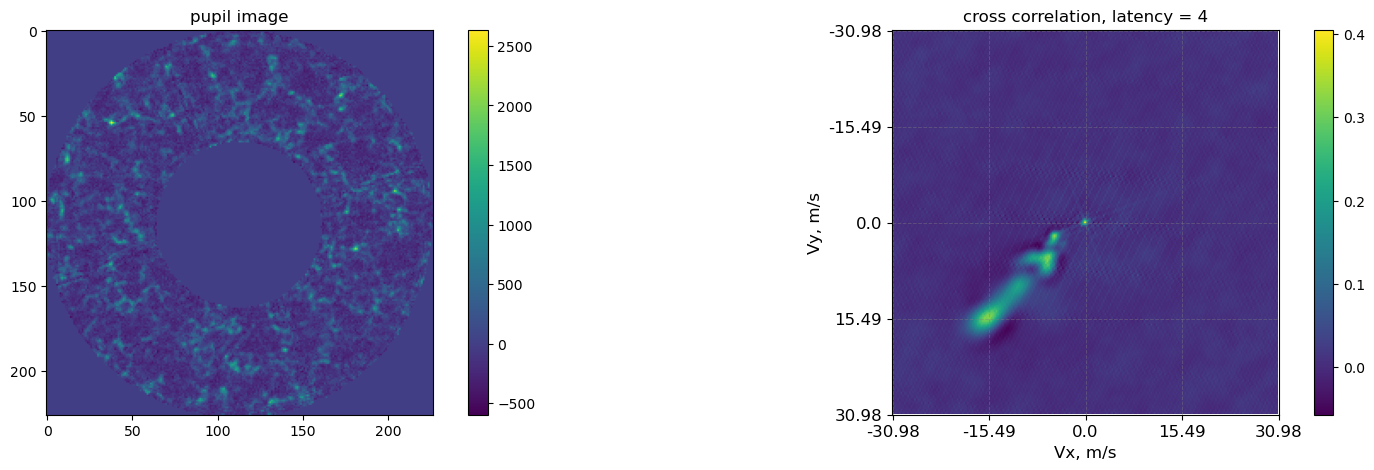

In [4]:
st = time.perf_counter()
with fits.open(file_bias) as f:
    f.info()
    bias = np.mean(f[0].data, axis=0, dtype=np.float32)
    
with fits.open(file) as f:
    f.info()
    sec_per_frame = 1 / f[0].header['FRATE']
    data = np.float32(f[0].data) - bias 
    
data = pupil(data)    
data_corr = correlate(data, latency)
v = (D / Dpix) / (latency * sec_per_frame)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))

fig.colorbar(ax.imshow(data[0], cmap=cmap), ax = ax)
ax.set_title('pupil image')
ax.grid(False)

fig.colorbar(ax2.imshow(data_corr, cmap=cmap), ax = ax2)
ax2.set_title(f'cross correlation, latency = {latency}')
x = np.round(v*np.linspace(-data_corr.shape[0]//2, data_corr.shape[0]//2, 5), 2)
ax2.set_xticks(np.linspace(0, data_corr.shape[1], 5))
ax2.set_yticks(np.linspace(0, data_corr.shape[0], 5))
ax2.set_xticklabels(x, fontsize=12)
ax2.set_yticklabels(x, fontsize=12)
ax2.set_ylabel('Vy, m/s', fontsize=12)
ax2.set_xlabel('Vx, m/s', fontsize=12)
ax2.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

print(' ')
print('time:', time.perf_counter()-st)

# подложки быть не должно (которая на фоне)

# черные области рядом с пиками - зоны Френеля. По радиусу этих зон можно посчитать дистанцию распространения

In [5]:
# def draw_correlate_with_velocity(data, D, Dpix, latency, sec_per_frame): 
#     v = (D / Dpix) / (latency * sec_per_frame)
    
#     x = np.round(v*np.linspace(-data.shape[0]//2, data.shape[0]//2, 5), 2)
#     fig = plt.figure()
#     ax = plt.axes()
#     im = plt.imshow(data, cmap = None)
#     ax.set_xticks(np.linspace(0, data.shape[1], 5))
#     ax.set_yticks(np.linspace(0, data.shape[0], 5))
#     ax.set_xticklabels(x, fontsize=12)
#     ax.set_yticklabels(x, fontsize=12)
#     ax.set_ylabel('Vy, m/s', fontsize=12)
#     ax.set_xlabel('Vx, m/s', fontsize=12)
#     cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
#     plt.colorbar(im, cax=cax)
#     ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

# draw_correlate_with_velocity(data_corr, D, Dpix, latency, sec_per_frame)

Cn2: 2.0874252262616215e-12


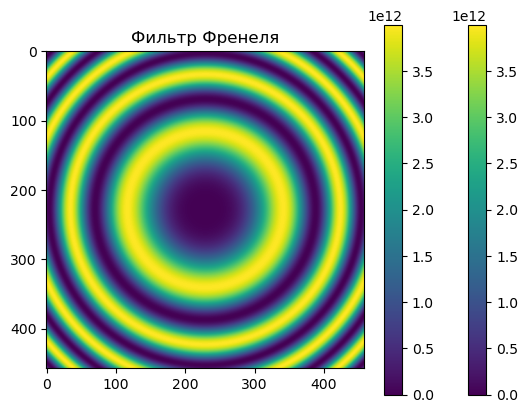

In [61]:
'''
Ex:

Для примера пусть Cn2 соответствует качеству изображения, равному 1 угловой секунде (типичное качество изображения) на длине 
волны 500 нм. Для удобства величину Cn2(z)dz рассматриваем как одну величину, обозначим ее C. Тогда:
    beta = 0.98 * lambda/r0 = 1, следовательно: r0 = 0.98*lambda*206265,
Пусть мы наблюдаем в зените, тогда параметр Фрида будет:
    r0 = (0.423*k^2 * C)^(-3/5), где k = 2*pi/lambda.
Далее можно просто выразить и посчитать С
'''
# Cn2_ex = pow((0.98*lambda_)*206265, -5/3) / (0.423*pow(2*np.pi/lambda_, 2))
Cn2_ex = 1*pow(10, -13)

n = 10 # полуширина центрального окна в кросс-корреляции                                                                          
k = np.max(data_corr[data_corr.shape[0]//2-n:data_corr.shape[0]//2+n, data_corr.shape[1]//2-n:data_corr.shape[1]//2+n]) \
    / np.max((gamma_mono(Cn2_ex, D, Dpix, z, lambda_) * c_jk(data[0], Dpix)))
Cn2 = Cn2_ex * k 
gamma_new = gamma_mono(Cn2, D, Dpix, z, lambda_) * c_jk(data[0], Dpix)

print('Cn2:', Cn2)

Text(0.5, 0.98, 'Монохроматический случай')

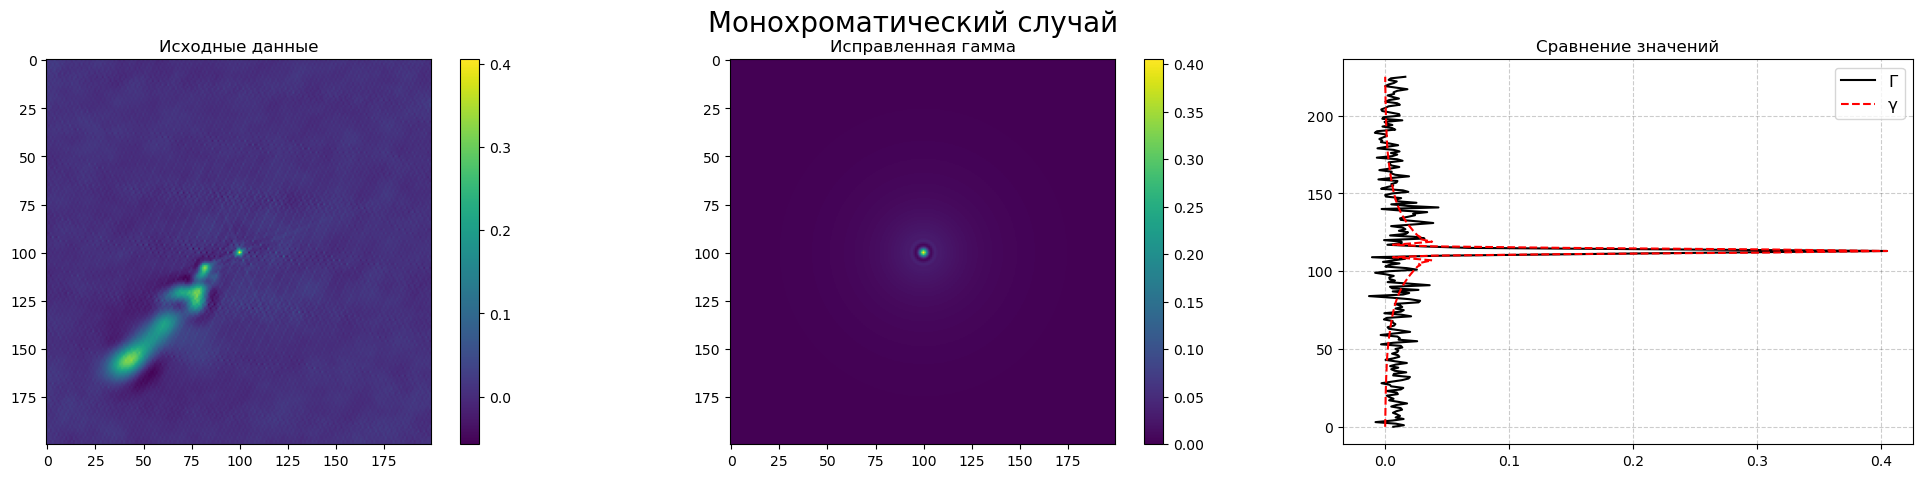

In [73]:
k = 100 # полуширина окна для отображения
centr = np.unravel_index(np.argmax(gamma_new), gamma_new.shape)

X = data_corr[:, data_corr.shape[1]//2]
Y = range(data_corr.shape[0])
X3 = gamma_new[centr[0]-data_corr.shape[0]//2:centr[0]+data_corr.shape[0]//2, gamma_new.shape[1]//2]
Y3 = range(data_corr.shape[0])

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

fig.colorbar(ax.imshow(data_corr[data_corr.shape[0]//2-k:data_corr.shape[0]//2+k, 
                                 data_corr.shape[1]//2-k:data_corr.shape[1]//2+k], cmap=cmap), ax = ax)
ax.grid(False)
ax.set_title('Исходные данные')

fig.colorbar(ax2.imshow(gamma_new[centr[0]-k:centr[0]+k, centr[1]-k:centr[1]+k], cmap=cmap), ax=ax2)
ax2.grid(False)
ax2.set_title('Исправленная гамма')

ax3.plot(X, Y, alpha = 1, label = 'original corr', color = 'black')
ax3.plot(X3, Y3, alpha = 1, ls = '--', label = 'corected gamma', color = 'red')
ax3.legend(['Γ', 'γ'], loc=1, prop={'size': 12})
ax3.grid(color = 'black', linestyle='--', alpha = 0.2)
ax3.set_title('Сравнение значений')

# fig.savefig('C:/astro/teor_corr2.png', bbox_inches='tight')
fig.suptitle('Монохроматический случай', fontsize=20)

In [67]:
Cn2_ex = 1 * pow(10, -13)
Vx = 0
Vy = 0
n = 10 # полуширина центрального окна в кросс-корреляции                                                                          
k = np.max(data_corr[data_corr.shape[0]//2-n:data_corr.shape[0]//2+n, 
                     data_corr.shape[1]//2-n:data_corr.shape[1]//2+n]) \
    / np.max((gamma_poly(Cn2_ex, D, Dpix, z, Vx, Vy, latency, sec_per_frame) * c_jk(data[0], Dpix)))

Cn2 = Cn2_ex * k 
gamma_new = gamma_poly(Cn2, D, Dpix, z, Vx, Vy, latency, sec_per_frame) * c_jk(data[0], Dpix)

print('Cn2:', Cn2)

Cn2: 1.41183229577238e-11


Text(0.5, 0.98, 'Полихроматический случай')

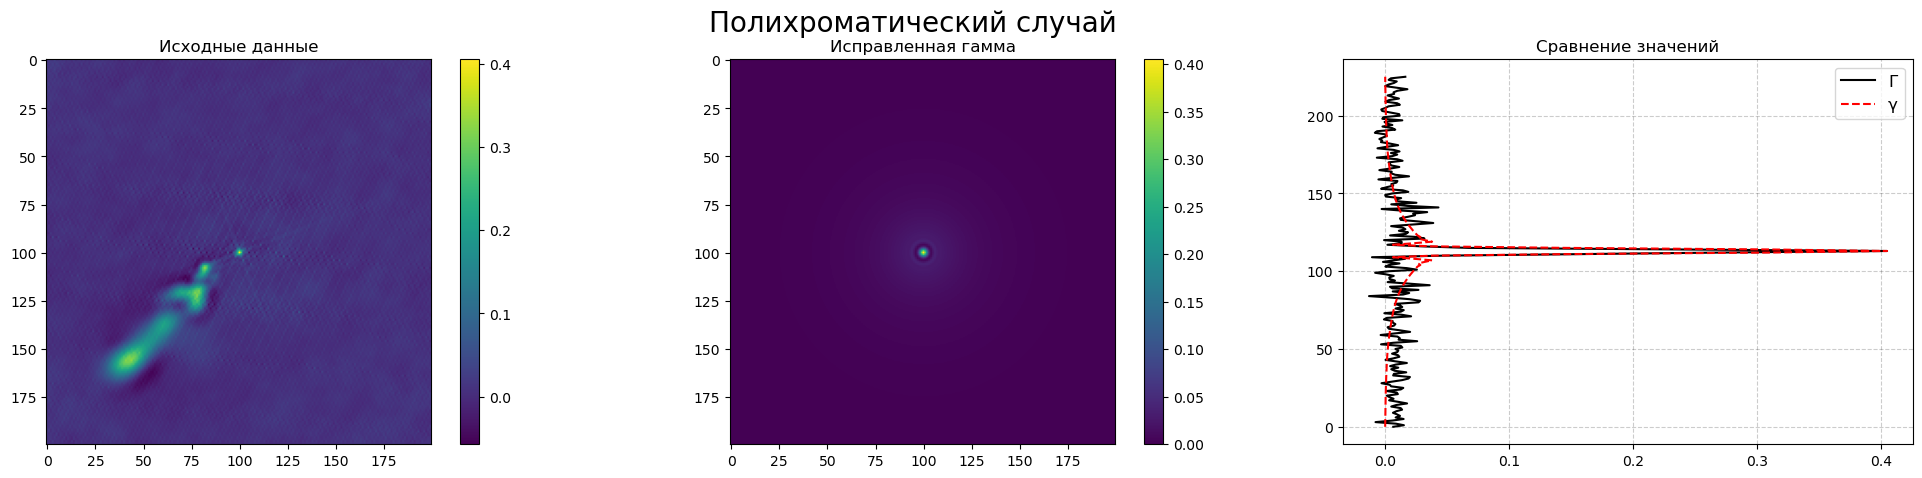

In [72]:
k = 100 # полуширина окна для отображения
centr = np.unravel_index(np.argmax(gamma_new), gamma_new.shape)

X = data_corr[:, data_corr.shape[1]//2]
Y = range(data_corr.shape[0])
X3 = gamma_new[centr[0]-data_corr.shape[0]//2:centr[0]+data_corr.shape[0]//2, gamma_new.shape[1]//2]
Y3 = range(data_corr.shape[0])

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

fig.colorbar(ax.imshow(data_corr[data_corr.shape[0]//2-k:data_corr.shape[0]//2+k, 
                                 data_corr.shape[1]//2-k:data_corr.shape[1]//2+k], cmap=cmap), ax = ax)
ax.grid(False)
ax.set_title('Исходные данные')

fig.colorbar(ax2.imshow(gamma_new[centr[0]-k:centr[0]+k, centr[1]-k:centr[1]+k], cmap=cmap), ax=ax2)
ax2.grid(False)
ax2.set_title('Исправленная гамма')

ax3.plot(X, Y, alpha = 1, label = 'original corr', color = 'black')
ax3.plot(X3, Y3, alpha = 1, ls = '--', label = 'corected gamma', color = 'red')
ax3.legend(['Γ', 'γ'], loc=1, prop={'size': 12})
ax3.grid(color = 'black', linestyle='--', alpha = 0.2)
ax3.set_title('Сравнение значений')

# fig.savefig('C:/astro/abs_corr_polychromatic.png', bbox_inches='tight')
fig.suptitle('Полихроматический случай', fontsize=20)

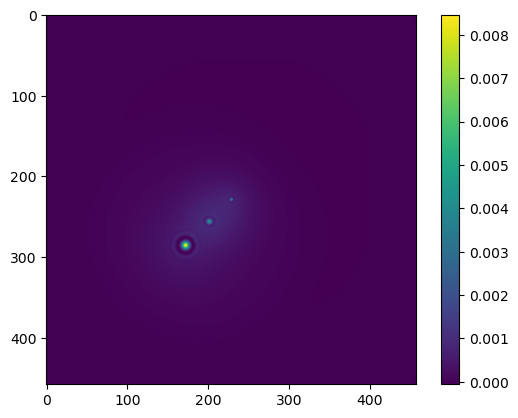

In [10]:
# Cn2 = [1*pow(10, -13), 1*pow(10, -13), 2*pow(10, -13)] 
# z = [2000, 5000, 12100]
# Vx = [0, -7.5, -15.56]
# Vy = [0, 7.5, 15.56]

# teor_corr1 = gamma_poly(Cn2[0], D, Dpix, z[0], Vx[0], Vy[0], latency, sec_per_frame) * c_jk(data[0], Dpix)
# teor_corr2 = gamma_poly(Cn2[1], D, Dpix, z[1], Vx[1], Vy[1], latency, sec_per_frame) * c_jk(data[0], Dpix)
# teor_corr3 = gamma_poly(Cn2[2], D, Dpix, z[2], Vx[2], Vy[2], latency, sec_per_frame) * c_jk(data[0], Dpix)

# teor_corr = teor_corr1 + teor_corr2 + teor_corr3

# plt.figure()
# plt.imshow(teor_corr)
# plt.colorbar()

# см функцию scipy optimize (в tg скинул). параметр p0 - начальное приближение - вектор размерности 30 (10 слоев, по три
# неизвестных на каждый слой: две скорости и Cn2.)